Part 1: Imports and Setup

In [241]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import rasterio
from rasterio.plot import show
import glob
from datetime import datetime
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import transforms

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Part 2: Data Loading and Preprocessing

In [242]:
class SatelliteImageDataset(Dataset):
    """Dataset for satellite super-resolution."""
    
    def __init__(self, csv_file, patch_size=100, scale_factor=4, transform=None, percentile_range=(2, 98)):
        """
        Args:
            csv_file: Path to the CSV file containing image paths
            patch_size: Size of input patches
            scale_factor: Upscaling factor
            transform: Optional transforms to apply
            percentile_range: Tuple of (low, high) percentiles for stretching
        """
        self.data_info = pd.read_csv(csv_file)
        self.patch_size = patch_size
        self.scale_factor = scale_factor
        self.transform = transform
        self.hr_size = patch_size * scale_factor
        self.percentile_range = percentile_range
        
    def __len__(self):
        return len(self.data_info)
    
    def __getitem__(self, idx):
        # Get file paths
        goes1_path = self.data_info.iloc[idx]['goes1_path']
        goes2_path = self.data_info.iloc[idx]['goes2_path']
        viirs_path = self.data_info.iloc[idx]['viirs_path']
        
        # Load images with percent stretch
        goes1 = self.load_image_with_stretch(goes1_path)
        goes2 = self.load_image_with_stretch(goes2_path)
        viirs = self.load_image_with_stretch(viirs_path)
        
        # Ensure viirs has the correct size (HR size)
        if viirs.shape[1:] != (self.hr_size, self.hr_size):
            viirs = F.interpolate(viirs.unsqueeze(0), size=(self.hr_size, self.hr_size), 
                                 mode='bilinear', align_corners=False).squeeze(0)
        
        # Ensure goes1 and goes2 have the correct size (LR size)
        if goes1.shape[1:] != (self.patch_size, self.patch_size):
            goes1 = F.interpolate(goes1.unsqueeze(0), size=(self.patch_size, self.patch_size), 
                                 mode='bilinear', align_corners=False).squeeze(0)
        
        if goes2.shape[1:] != (self.patch_size, self.patch_size):
            goes2 = F.interpolate(goes2.unsqueeze(0), size=(self.patch_size, self.patch_size), 
                                 mode='bilinear', align_corners=False).squeeze(0)
        
        # Apply transforms if any
        if self.transform:
            goes1 = self.transform(goes1)
            goes2 = self.transform(goes2)
            viirs = self.transform(viirs)
        
        return (goes1, goes2), viirs
    
    def load_image_with_stretch(self, path):
        """Load an image as a tensor with percent stretch applied."""
        with rasterio.open(path) as src:
            # Read the first band
            image = src.read(1).astype(np.float32)
            
            # Handle NaN and Inf values
            if np.isnan(image).any() or np.isinf(image).any():
                valid_mask = ~(np.isnan(image) | np.isinf(image))
                if valid_mask.any():
                    valid_mean = image[valid_mask].mean()
                    image = np.where(valid_mask, image, valid_mean)
                else:
                    image = np.zeros_like(image)
            
            # Apply percent stretch
            p_low, p_high = self.percentile_range
            low_val, high_val = np.percentile(image, (p_low, p_high))
            
            # Avoid division by zero
            if high_val > low_val:
                image = np.clip((image - low_val) / (high_val - low_val), 0, 1)
            else:
                image = np.zeros_like(image)
            
            # Convert to tensor
            image_tensor = torch.from_numpy(image).unsqueeze(0)  # Add channel dimension
            
            return image_tensor

GOES-1 stats: min=311.0, max=1689.0, mean=464.33
GOES-2 stats: min=293.0, max=1742.0, mean=446.93
VIIRS stats: min=271.5158996582031, max=65535.0, mean=386.12


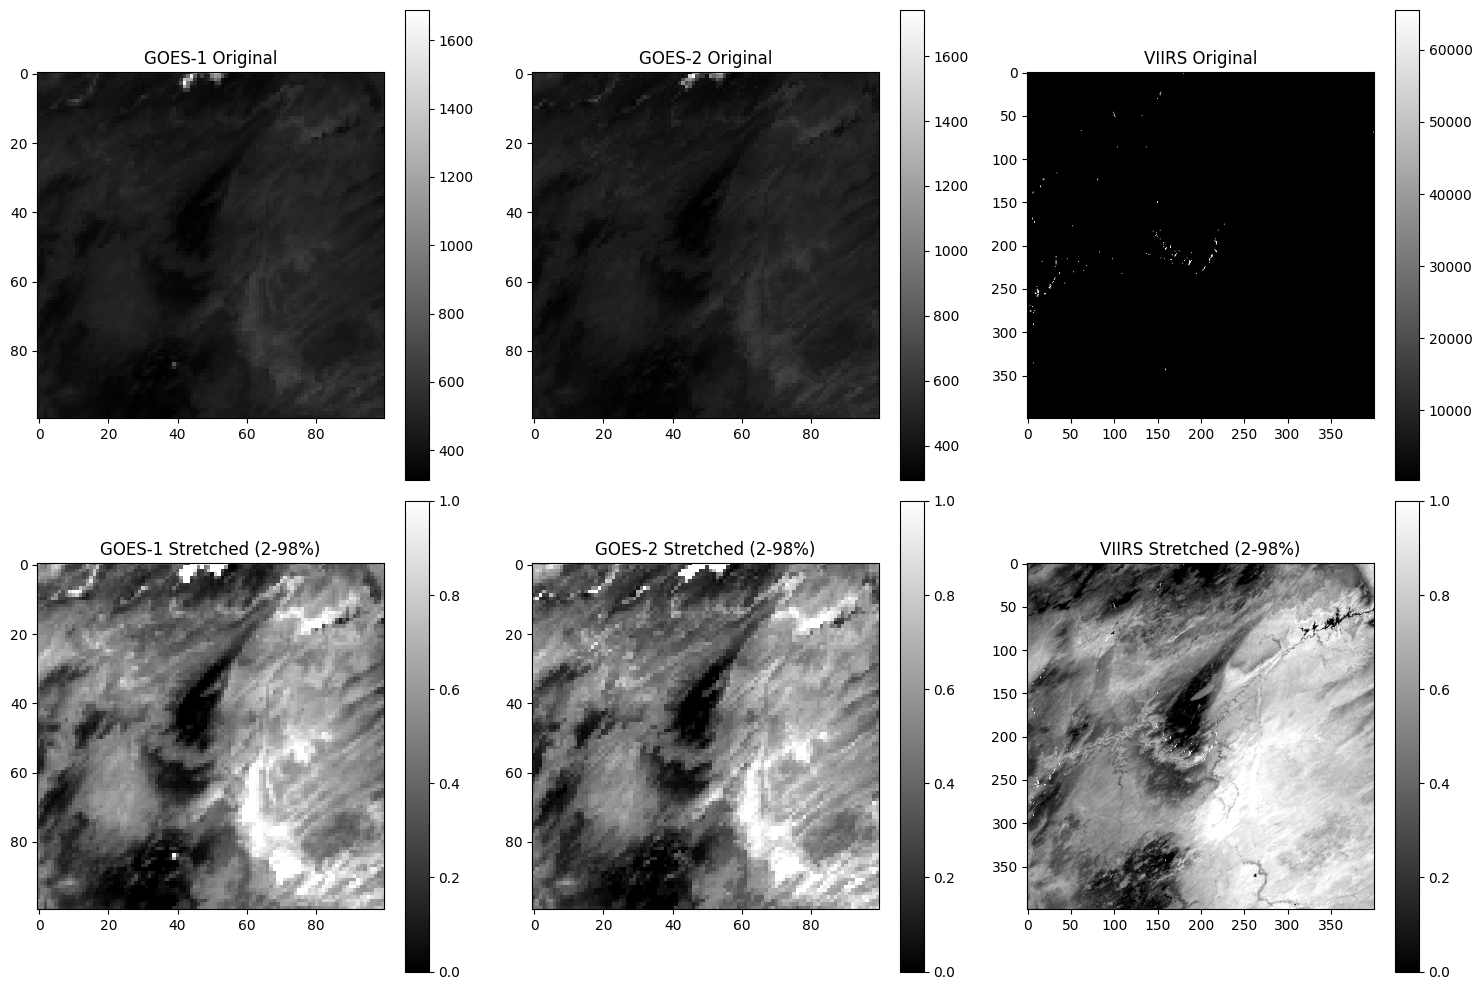

GOES-1 2% percentile: 333.00, 98% percentile: 611.02
GOES-2 2% percentile: 314.00, 98% percentile: 597.00
VIIRS 2% percentile: 295.92, 98% percentile: 326.64


In [243]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio

def visualize_with_percent_stretch(goes1_path, goes2_path, viirs_path, percentile_range=(2, 98)):
    """
    Visualize satellite images with percent stretch for better contrast.
    
    Args:
        goes1_path: Path to GOES-16 image
        goes2_path: Path to GOES-17 image
        viirs_path: Path to VIIRS image
        percentile_range: Tuple of (low, high) percentiles for stretching
    """
    # Load the images
    with rasterio.open(goes1_path) as src:
        goes1 = src.read(1)
        print(f"GOES-1 stats: min={goes1.min()}, max={goes1.max()}, mean={goes1.mean():.2f}")
    
    with rasterio.open(goes2_path) as src:
        goes2 = src.read(1)
        print(f"GOES-2 stats: min={goes2.min()}, max={goes2.max()}, mean={goes2.mean():.2f}")
    
    with rasterio.open(viirs_path) as src:
        viirs = src.read(1)
        print(f"VIIRS stats: min={viirs.min()}, max={viirs.max()}, mean={viirs.mean():.2f}")
    
    # Apply percent stretch to each image
    p_low, p_high = percentile_range
    
    # GOES-1
    g1_p_low, g1_p_high = np.percentile(goes1, (p_low, p_high))
    goes1_stretched = np.clip((goes1 - g1_p_low) / (g1_p_high - g1_p_low), 0, 1)
    
    # GOES-2
    g2_p_low, g2_p_high = np.percentile(goes2, (p_low, p_high))
    goes2_stretched = np.clip((goes2 - g2_p_low) / (g2_p_high - g2_p_low), 0, 1)
    
    # VIIRS
    v_p_low, v_p_high = np.percentile(viirs, (p_low, p_high))
    viirs_stretched = np.clip((viirs - v_p_low) / (v_p_high - v_p_low), 0, 1)
    
    # Create figure for visualization
    plt.figure(figsize=(15, 10))
    
    # Original images
    plt.subplot(2, 3, 1)
    plt.imshow(goes1, cmap='gray')
    plt.title('GOES-1 Original')
    plt.colorbar()
    
    plt.subplot(2, 3, 2)
    plt.imshow(goes2, cmap='gray')
    plt.title('GOES-2 Original')
    plt.colorbar()
    
    plt.subplot(2, 3, 3)
    plt.imshow(viirs, cmap='gray')
    plt.title('VIIRS Original')
    plt.colorbar()
    
    # Stretched images
    plt.subplot(2, 3, 4)
    plt.imshow(goes1_stretched, cmap='gray')
    plt.title(f'GOES-1 Stretched ({p_low}-{p_high}%)')
    plt.colorbar()
    
    plt.subplot(2, 3, 5)
    plt.imshow(goes2_stretched, cmap='gray')
    plt.title(f'GOES-2 Stretched ({p_low}-{p_high}%)')
    plt.colorbar()
    
    plt.subplot(2, 3, 6)
    plt.imshow(viirs_stretched, cmap='gray')
    plt.title(f'VIIRS Stretched ({p_low}-{p_high}%)')
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()
    
    # Print percentile values
    print(f"GOES-1 {p_low}% percentile: {g1_p_low:.2f}, {p_high}% percentile: {g1_p_high:.2f}")
    print(f"GOES-2 {p_low}% percentile: {g2_p_low:.2f}, {p_high}% percentile: {g2_p_high:.2f}")
    print(f"VIIRS {p_low}% percentile: {v_p_low:.2f}, {p_high}% percentile: {v_p_high:.2f}")
    
    return goes1_stretched, goes2_stretched, viirs_stretched

# Example usage
goes1_path = r'Processed\ONLY_TIF\2020-05\2020-05-01_19-18\clipped_geo16.tif'
goes2_path = r'Processed\ONLY_TIF\2020-05\2020-05-01_19-18\clipped_geo17.tif'
viirs_path = r'Processed\ONLY_TIF\2020-05\2020-05-01_19-18\combined_clip.tif'

# Try different percentile ranges
stretched_2_98 = visualize_with_percent_stretch(goes1_path, goes2_path, viirs_path, (2, 98))

Part 3: Data Module for PyTorch Lightning


In [244]:
class SatelliteDataModule(pl.LightningDataModule):
    """PyTorch Lightning data module for satellite imagery."""
    
    def __init__(self, csv_file, batch_size=8, patch_size=100, scale_factor=4, num_workers=4, 
                 transform=None, percentile_range=(2, 98)):
        """
        Args:
            csv_file: Path to the CSV file containing image paths
            batch_size: Number of samples per batch
            patch_size: Size of input patches
            scale_factor: Upscaling factor
            num_workers: Number of workers for data loading
            transform: Optional transforms to apply
            percentile_range: Tuple of (low, high) percentiles for stretching
        """
        super().__init__()
        self.csv_file = csv_file
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.scale_factor = scale_factor
        self.num_workers = num_workers
        self.transform = transform
        self.percentile_range = percentile_range
        
    def setup(self, stage=None):
        # Create dataset
        dataset = SatelliteImageDataset(
            csv_file=self.csv_file, 
            patch_size=self.patch_size, 
            scale_factor=self.scale_factor,
            transform=self.transform,
            percentile_range=self.percentile_range
        )
        
        # Split dataset
        train_size = int(0.8 * len(dataset))
        val_size = int(0.1 * len(dataset))
        test_size = len(dataset) - train_size - val_size
        
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(
            dataset, [train_size, val_size, test_size],
            generator=torch.Generator().manual_seed(42)
        )
        
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, 
            batch_size=self.batch_size, 
            shuffle=True, 
            num_workers=self.num_workers,
            pin_memory=True
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.val_dataset, 
            batch_size=self.batch_size, 
            shuffle=False, 
            num_workers=self.num_workers,
            pin_memory=True
        )
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset, 
            batch_size=self.batch_size, 
            shuffle=False, 
            num_workers=self.num_workers,
            pin_memory=True
        )

In [245]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    """Basic convolutional block with batch normalization and ReLU activation"""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class DeeperEncoder(nn.Module):
    def __init__(self, in_channels=1, features=[64, 128, 256, 512, 1024]):
        super(DeeperEncoder, self).__init__()
        
        self.layers = nn.ModuleList()
        prev_channels = in_channels
        
        for feature in features:
            self.layers.append(
                nn.Sequential(
                    nn.Conv2d(prev_channels, feature, kernel_size=3, padding=1),
                    nn.BatchNorm2d(feature),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(feature, feature, kernel_size=3, padding=1),
                    nn.BatchNorm2d(feature),
                    nn.ReLU(inplace=True),
                    # Add a third convolutional layer for more depth
                    nn.Conv2d(feature, feature, kernel_size=3, padding=1),
                    nn.BatchNorm2d(feature),
                    nn.ReLU(inplace=True)
                )
            )
            prev_channels = feature
        
    def forward(self, x):
        features = []
        for i, layer in enumerate(self.layers):
            x = layer(x)
            features.append(x)
            if i < len(self.layers) - 1:
                x = F.avg_pool2d(x, kernel_size=2)  # Downsampling
        return x, features

class DeeperFusionModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DeeperFusionModule, self).__init__()
        
        mid_channels = in_channels // 2
        
        self.fusion = nn.Sequential(
            # First layer - reduce channels
            nn.Conv2d(in_channels * 2, in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            
            # Second layer - process features
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            
            # Third layer - bottleneck
            nn.Conv2d(in_channels, mid_channels, kernel_size=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            
            # Fourth layer - expand
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            
            # Fifth layer - final refinement
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x1, x2):
        # Concatenate features from both encoders
        x = torch.cat([x1, x2], dim=1)
        return self.fusion(x)

class DeeperDecoder(nn.Module):
    def __init__(self, in_channels, out_channels=1, scale_factor=4):
        super(DeeperDecoder, self).__init__()
        
        self.upscale_factor = scale_factor
        
        # Deeper upsampling layers
        self.upconv = nn.Sequential(
            # First block
            nn.Conv2d(in_channels, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            
            # Second block
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            # Third block
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            # Fourth block
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        # Final layer to produce the output
        self.final = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, out_channels, kernel_size=3, padding=1)
        )
        
    def forward(self, x):
        x = self.upconv(x)
        # Upscale to the target resolution
        x = F.interpolate(x, scale_factor=self.upscale_factor, mode='bilinear', align_corners=False)
        return self.final(x)

class SatelliteSuperResolutionModel(nn.Module):
    """Complete super-resolution model for satellite imagery"""
    def __init__(self, in_channels=1, fusion_channels=1024, out_channels=1, scale_factor=4):
        super(SatelliteSuperResolutionModel, self).__init__()
        
        # Encoders for the two low-resolution images
        self.encoder1 = DeeperEncoder(in_channels=in_channels)
        self.encoder2 = DeeperEncoder(in_channels=in_channels)
        
        # Fusion module
        self.fusion = DeeperFusionModule(fusion_channels, fusion_channels)
        
        # Decoder
        self.decoder = DeeperDecoder(fusion_channels, out_channels, scale_factor)
        
    def forward(self, x1, x2):
        # Extract features from both low-resolution images
        feat1,_ = self.encoder1(x1)
        feat2,_ = self.encoder2(x2)

        
        # Fuse features
        fused = self.fusion(feat1, feat2)
        
        # Decode and generate high-resolution output
        return self.decoder(fused)

In [246]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping


class SatelliteSuperResolutionSystem(pl.LightningModule):
    def __init__(self, in_channels=1, fusion_channels=1024, out_channels=1, scale_factor=4, lr=1e-4):
        super(SatelliteSuperResolutionSystem, self).__init__()
        self.model = SatelliteSuperResolutionModel(
            in_channels=in_channels,
            fusion_channels=fusion_channels,
            out_channels=out_channels,
            scale_factor=scale_factor
        )
        self.lr = lr
        
        # Loss functions
        self.l1_loss = nn.L1Loss()
        self.mse_loss = nn.MSELoss()
        
    def forward(self, x1, x2):
        return self.model(x1, x2)
    
    def training_step(self, batch, batch_idx):
        # Fix the unpacking to match your dataset's return format
        (lr_img1, lr_img2), hr_target = batch
        
        # Generate SR image
        sr_output = self.model(lr_img1, lr_img2)
        
        # Calculate losses
        l1 = self.l1_loss(sr_output, hr_target)
        mse = self.mse_loss(sr_output, hr_target)
        
        # Combined loss (you can adjust weights as needed)
        loss = l1 + mse
        
        # Log metrics
        self.log('train_l1', l1, prog_bar=True)
        self.log('train_mse', mse, prog_bar=True)
        self.log('train_loss', loss, prog_bar=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        # Fix the unpacking here too
        (lr_img1, lr_img2), hr_target = batch
        sr_output = self.model(lr_img1, lr_img2)
        
        l1 = self.l1_loss(sr_output, hr_target)
        mse = self.mse_loss(sr_output, hr_target)
        loss = l1 + mse
        
        # Calculate PSNR (Peak Signal-to-Noise Ratio)
        psnr = 10 * torch.log10(1 / mse)
        
        self.log('val_l1', l1, prog_bar=True)
        self.log('val_mse', mse, prog_bar=True)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_psnr', psnr, prog_bar=True)
        
        # Save sample images periodically
        if batch_idx == 0:
            # You might want to implement a visualization callback
            pass
        
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=5, verbose=True
        )
        
        return {
            'optimizer': optimizer,
            'lr_scheduler': scheduler,
            'monitor': 'val_loss'
        }


In [247]:
def train_model(
    csv_file='Processed/tif_files_with_ids.csv',
    batch_size=32,
    patch_size=64,
    scale_factor=4,
    in_channels=1,
    fusion_channels=1024,  # Changed from base_filters to fusion_channels
    out_channels=1,       # Added out_channels parameter
    learning_rate=1e-4,
    max_epochs=30,
    checkpoint_dir='checkpoints',
    log_dir='logs',
    percentile_range=(2, 98)
):
    """
    Train the satellite super-resolution model with percent stretch.
    
    Args:
        csv_file: Path to the CSV file containing image paths
        batch_size: Number of samples per batch
        patch_size: Size of input patches
        scale_factor: Upscaling factor
        in_channels: Number of input channels
        fusion_channels: Number of channels in fusion module
        out_channels: Number of output channels
        learning_rate: Learning rate for the optimizer
        max_epochs: Maximum number of training epochs
        checkpoint_dir: Directory to save checkpoints
        log_dir: Directory to save logs
        percentile_range: Tuple of (low, high) percentiles for stretching
    """
    # Create directories if they don't exist
    os.makedirs(checkpoint_dir, exist_ok=True)
    os.makedirs(log_dir, exist_ok=True)
    
    # Initialize data module with percent stretch
    data_module = SatelliteDataModule(
        csv_file=csv_file,
        batch_size=batch_size,
        patch_size=patch_size,
        scale_factor=scale_factor,
        num_workers=0,  # Use 0 workers to avoid multiprocessing issues
        percentile_range=percentile_range
    )
    
    # Initialize model with correct parameters
    model = SatelliteSuperResolutionSystem(
        in_channels=in_channels,
        fusion_channels=fusion_channels,  # Changed from base_filters
        out_channels=out_channels,        # Added out_channels
        scale_factor=scale_factor,
        lr=learning_rate
    )
    
    # Set up callbacks
    checkpoint_callback = ModelCheckpoint(
        dirpath=checkpoint_dir,
        filename='satellite-sr-one_patch--{epoch:02d}-{val_loss:.4f}',
        save_top_k=3,
        monitor='val_loss',
        mode='min'
    )
    
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        mode='min'
    )
    
    # Set up logger
    logger = TensorBoardLogger(log_dir, name='satellite-sr')
    
    # Initialize trainer
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        callbacks=[checkpoint_callback, early_stopping],
        logger=logger,
        log_every_n_steps=10,
        accelerator='auto',  # Use GPU if available
        devices=1
    )
    
    # Train the model
    trainer.fit(model, data_module)
    
    return model, trainer

In [248]:
import torch
import matplotlib.pyplot as plt
import rasterio
import numpy as np
from rasterio.plot import show
import torch.nn.functional as F

def load_image(path, normalize=False):
    """Load an image as a tensor."""
    with rasterio.open(path) as src:
        # Read the first band (assuming single-channel)
        image = src.read(1).astype(np.float32)
        
        # Get metadata for saving later
        metadata = src.meta.copy()
        
        # # Normalize to [0, 1] if requested
        # if normalize:
        #     min_val = image.min()
        #     max_val = image.max()
        #     if max_val > min_val:
        #         image = (image - min_val) / (max_val - min_val)
        
        # Convert to tensor
        image_tensor = torch.from_numpy(image).unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
        
        return image_tensor, metadata

def save_image(image_tensor, output_path, metadata=None, denormalize=False, min_val=0, max_val=1):
    """Save a tensor as an image."""
    # Convert to numpy and remove batch and channel dimensions
    image = image_tensor.squeeze().cpu().numpy()
    
    # Denormalize if requested
    # if denormalize:
    #     image = image * (max_val - min_val) + min_val
    
    # Update metadata if provided
    if metadata is not None:
        # Update resolution if this is a super-resolved image
        if 'transform' in metadata:
            # Scale the pixel size by the super-resolution factor
            # This assumes the super-resolution factor is the ratio of output to input size
            scale_factor = image.shape[0] / metadata['height']
            transform = metadata['transform']
            new_pixel_width = transform.a / scale_factor
            new_pixel_height = transform.e / scale_factor
            metadata.update({
                'height': image.shape[0],
                'width': image.shape[1],
                'transform': rasterio.Affine(new_pixel_width, transform.b, transform.c,
                                            transform.d, new_pixel_height, transform.f)
            })
    
    # Write the image
    with rasterio.open(output_path, 'w', **metadata) as dst:
        dst.write(image.astype(rasterio.float32), 1)

def create_super_resolution_image(model_path, goes1_path, goes2_path, output_path, percentile_range=(2, 98)):
    """Create a super-resolution image using the trained model with percent stretch."""
    # Load the model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SatelliteSuperResolutionSystem.load_from_checkpoint(model_path)
    model.to(device)
    model.eval()
    
    # Load the input images with percent stretch
    with rasterio.open(goes1_path) as src:
        goes1_img = src.read(1).astype(np.float32)
        goes1_meta = src.meta.copy()
        
        # Apply percent stretch
        p_low, p_high = percentile_range
        g1_low, g1_high = np.percentile(goes1_img, (p_low, p_high))
        goes1_img = np.clip((goes1_img - g1_low) / (g1_high - g1_low), 0, 1)
    
    with rasterio.open(goes2_path) as src:
        goes2_img = src.read(1).astype(np.float32)
        
        # Apply percent stretch
        g2_low, g2_high = np.percentile(goes2_img, (p_low, p_high))
        goes2_img = np.clip((goes2_img - g2_low) / (g2_high - g2_low), 0, 1)
    
    # Convert to tensors
    goes1_tensor = torch.from_numpy(goes1_img).unsqueeze(0).unsqueeze(0).to(device)
    goes2_tensor = torch.from_numpy(goes2_img).unsqueeze(0).unsqueeze(0).to(device)
    
    # Generate super-resolution image
    with torch.no_grad():
        sr_output = model(goes1_tensor, goes2_tensor)
    
    # Convert back to numpy
    sr_img = sr_output.squeeze().cpu().numpy()
    
    # Update metadata for the super-resolved image
    scale_factor = 4  # Assuming scale factor of 4
    goes1_meta.update({
        'height': sr_img.shape[0],
        'width': sr_img.shape[1],
        'transform': rasterio.Affine(
            goes1_meta['transform'].a / scale_factor,
            goes1_meta['transform'].b,
            goes1_meta['transform'].c,
            goes1_meta['transform'].d,
            goes1_meta['transform'].e / scale_factor,
            goes1_meta['transform'].f
        )
    })
    
    # Save the output
    with rasterio.open(output_path, 'w', **goes1_meta) as dst:
        dst.write(sr_img.astype(rasterio.float32), 1)
    
    return sr_img

def visualize_results(lr_path1, lr_path2, sr_path, hr_path=None, percentile_range=(2, 98)):
    """Visualize the super-resolution results with percent stretch."""
    plt.figure(figsize=(15, 10))
    
    # Load and display the first low-resolution image
    with rasterio.open(lr_path1) as src:
        lr_img1 = src.read(1)
        # Apply percent stretch for visualization
        p_low, p_high = percentile_range
        lr1_low, lr1_high = np.percentile(lr_img1, (p_low, p_high))
        lr_img1_stretched = np.clip((lr_img1 - lr1_low) / (lr1_high - lr1_low), 0, 1)
    
    plt.subplot(2, 2, 1)
    plt.imshow(lr_img1_stretched, cmap='gray')
    plt.title(f'GOES-1 ({p_low}-{p_high}% stretch)')
    plt.colorbar()
    
    # Load and display the second low-resolution image
    with rasterio.open(lr_path2) as src:
        lr_img2 = src.read(1)
        # Apply percent stretch for visualization
        lr2_low, lr2_high = np.percentile(lr_img2, (p_low, p_high))
        lr_img2_stretched = np.clip((lr_img2 - lr2_low) / (lr2_high - lr2_low), 0, 1)
    
    plt.subplot(2, 2, 2)
    plt.imshow(lr_img2_stretched, cmap='gray')
    plt.title(f'GOES-2 ({p_low}-{p_high}% stretch)')
    plt.colorbar()
    
    # Load and display the super-resolution output
    with rasterio.open(sr_path) as src:
        sr_img = src.read(1)
        # Apply percent stretch for visualization
        sr_low, sr_high = np.percentile(sr_img, (p_low, p_high))
        sr_img_stretched = np.clip((sr_img - sr_low) / (sr_high - sr_low), 0, 1)
    
    plt.subplot(2, 2, 3)
    plt.imshow(sr_img_stretched, cmap='gray')
    plt.title(f'Super Resolution ({p_low}-{p_high}% stretch)')
    plt.colorbar()
    
    # Load and display the high-resolution target if available
    if hr_path:
        with rasterio.open(hr_path) as src:
            hr_img = src.read(1)
            # Apply percent stretch for visualization
            hr_low, hr_high = np.percentile(hr_img, (p_low, p_high))
            hr_img_stretched = np.clip((hr_img - hr_low) / (hr_high - hr_low), 0, 1)
        
        plt.subplot(2, 2, 4)
        plt.imshow(hr_img_stretched, cmap='gray')
        plt.title(f'VIIRS Target ({p_low}-{p_high}% stretch)')
        plt.colorbar()
    
    plt.tight_layout()
    plt.show()

# model, trainer = train_model(percentile_range=(2, 98))



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory D:\sat\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name     | Type                          | Params | Mode 
-------------------------------------------------------------------
0 | model    | SatelliteSuperResolutionModel | 115 M  | train
1 | l1_loss  | L1Loss                        | 0      | train
2 | mse_loss | MSELoss                       | 0      | train
-------------------------------------------------------------------
115 M     Trainable params
0         Non-t

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:128: UserWarning: Using a target size (torch.Size([32, 1, 256, 256])) that is different to the input size (torch.Size([32, 1, 16, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (16) must match the size of tensor b (256) at non-singleton dimension 3

In [249]:
class EnhancedSatelliteSuperResolutionModel(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, scale_factor=4, base_filters=64):
        super(EnhancedSatelliteSuperResolutionModel, self).__init__()
        
        # Deeper encoder for first image
        self.encoder1 = nn.Sequential(
            # First block
            nn.Conv2d(in_channels, base_filters, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_filters, base_filters, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters),
            nn.ReLU(inplace=True),
            
            # Second block
            nn.Conv2d(base_filters, base_filters*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters*2),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_filters*2, base_filters*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters*2),
            nn.ReLU(inplace=True),
            
            # Third block
            nn.Conv2d(base_filters*2, base_filters*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters*4),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_filters*4, base_filters*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters*4),
            nn.ReLU(inplace=True)
        )
        
        # Identical encoder for second image
        self.encoder2 = nn.Sequential(
            # First block
            nn.Conv2d(in_channels, base_filters, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_filters, base_filters, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters),
            nn.ReLU(inplace=True),
            
            # Second block
            nn.Conv2d(base_filters, base_filters*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters*2),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_filters*2, base_filters*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters*2),
            nn.ReLU(inplace=True),
            
            # Third block
            nn.Conv2d(base_filters*2, base_filters*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters*4),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_filters*4, base_filters*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters*4),
            nn.ReLU(inplace=True)
        )
        
        # Enhanced fusion module
        self.fusion = nn.Sequential(
            nn.Conv2d(base_filters*8, base_filters*8, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters*8),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_filters*8, base_filters*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters*4),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_filters*4, base_filters*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters*4),
            nn.ReLU(inplace=True)
        )
        
        # Deeper upsampling module
        self.upsampling = nn.Sequential(
            # Pre-upsampling processing
            nn.Conv2d(base_filters*4, base_filters*8, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters*8),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_filters*8, base_filters*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_filters*4),
            nn.ReLU(inplace=True),
            
            # Upsampling using PixelShuffle (more efficient than interpolation)
            nn.Conv2d(base_filters*4, out_channels * (scale_factor**2), kernel_size=3, padding=1),
            nn.PixelShuffle(scale_factor)
        )
        
    def forward(self, x1, x2):
        # Encode both inputs
        feat1 = self.encoder1(x1)
        feat2 = self.encoder2(x2)
        
        # Concatenate and fuse
        concat = torch.cat([feat1, feat2], dim=1)
        fused = self.fusion(concat)
        
        # Upsample
        output = self.upsampling(fused)
        
        return output

# Update the Lightning module to use this enhanced model
class EnhancedSatelliteSuperResolutionSystem(pl.LightningModule):
    def __init__(self, in_channels=1, out_channels=1, scale_factor=4, base_filters=64, lr=1e-4):
        super(EnhancedSatelliteSuperResolutionSystem, self).__init__()
        
        self.model = EnhancedSatelliteSuperResolutionModel(
            in_channels, out_channels, scale_factor, base_filters
        )
        self.l1_loss = nn.L1Loss()
        self.mse_loss = nn.MSELoss()
        self.lr = lr
        
        # Save hyperparameters for checkpointing
        self.save_hyperparameters()
        
    def forward(self, x1, x2):
        return self.model(x1, x2)
    
    def training_step(self, batch, batch_idx):
        (lr_img1, lr_img2), hr_target = batch
        
        # Generate SR image
        sr_output = self(lr_img1, lr_img2)
        
        # Calculate losses
        l1 = self.l1_loss(sr_output, hr_target)
        mse = self.mse_loss(sr_output, hr_target)
        
        # Combined loss
        loss = l1 + mse
        
        # Log metrics
        self.log('train_l1', l1, prog_bar=True)
        self.log('train_mse', mse, prog_bar=True)
        self.log('train_loss', loss, prog_bar=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        (lr_img1, lr_img2), hr_target = batch
        
        # Generate SR image
        sr_output = self(lr_img1, lr_img2)
        
        # Calculate losses
        l1 = self.l1_loss(sr_output, hr_target)
        mse = self.mse_loss(sr_output, hr_target)
        loss = l1 + mse
        
        # Calculate PSNR
        psnr = 10 * torch.log10(1 / (mse + 1e-8))
        
        # Log metrics
        self.log('val_l1', l1, prog_bar=True)
        self.log('val_mse', mse, prog_bar=True)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_psnr', psnr, prog_bar=True)
        
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=5, verbose=True
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': scheduler,
            'monitor': 'val_loss'
        }

In [251]:
def train_model(
    csv_file='Processed/tif_files_with_ids.csv',
    batch_size=4,
    patch_size=100,
    scale_factor=4,
    in_channels=1,
    out_channels=1,
    base_filters=64,
    learning_rate=1e-4,
    max_epochs=4,
    checkpoint_dir='checkpoints one patch',
    log_dir='logs',
    percentile_range=(2, 98)
):
    """
    Train the enhanced satellite super-resolution model with percent stretch.
    """
    # Create directories if they don't exist
    os.makedirs(checkpoint_dir, exist_ok=True)
    os.makedirs(log_dir, exist_ok=True)
    
    # Initialize data module with percent stretch
    data_module = SatelliteDataModule(
        csv_file=csv_file,
        batch_size=batch_size,
        patch_size=patch_size,
        scale_factor=scale_factor,
        num_workers=0,
        percentile_range=percentile_range
    )
    
    # Initialize enhanced model
    model = EnhancedSatelliteSuperResolutionSystem(
        in_channels=in_channels,
        out_channels=out_channels,
        scale_factor=scale_factor,
        base_filters=base_filters,
        lr=learning_rate
    )
    
    # Set up callbacks
    checkpoint_callback = ModelCheckpoint(
        dirpath=checkpoint_dir,
        filename='enhanced-sr-{epoch:02d}-{val_psnr:.2f}',
        save_top_k=3,
        monitor='val_psnr',
        mode='max'
    )
    
    early_stopping = EarlyStopping(
        monitor='val_psnr',
        patience=15,
        mode='max'
    )
    
    # Set up logger
    logger = TensorBoardLogger(log_dir, name='enhanced-sr')
    
    # Initialize trainer
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        callbacks=[checkpoint_callback, early_stopping],
        logger=logger,
        log_every_n_steps=10,
        accelerator='auto',
        devices=1,
        gradient_clip_val=0.1  # Add gradient clipping for stability
    )
    
    # Train the model
    trainer.fit(model, data_module)
    
    return model, trainer
model, trainer = train_model(percentile_range=(2, 98))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name     | Type                                  | Params | Mode 
---------------------------------------------------------------------------
0 | model    | EnhancedSatelliteSuperResolutionModel | 8.8 M  | train
1 | l1_loss  | L1Loss                                | 0      | train
2 | mse_loss | MSELoss                               | 0      | train
---------------------------------------------------------------------------
8.8 M     Trainable params
0         Non-trainable params
8.8 M     Total params
35.290    Total estimated model params size (MB)
60        Modules in train mode
0         Modules in e

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 3: 100%|██████████| 252/252 [38:08<00:00,  0.11it/s, v_num=2, train_l1=0.146, train_mse=0.0335, train_loss=0.179, val_l1=0.170, val_mse=0.0533, val_loss=0.223, val_psnr=13.10]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 252/252 [38:11<00:00,  0.11it/s, v_num=2, train_l1=0.146, train_mse=0.0335, train_loss=0.179, val_l1=0.170, val_mse=0.0533, val_loss=0.223, val_psnr=13.10]


Using device: cuda
Model loaded successfully
Processing entire image of size 100x100


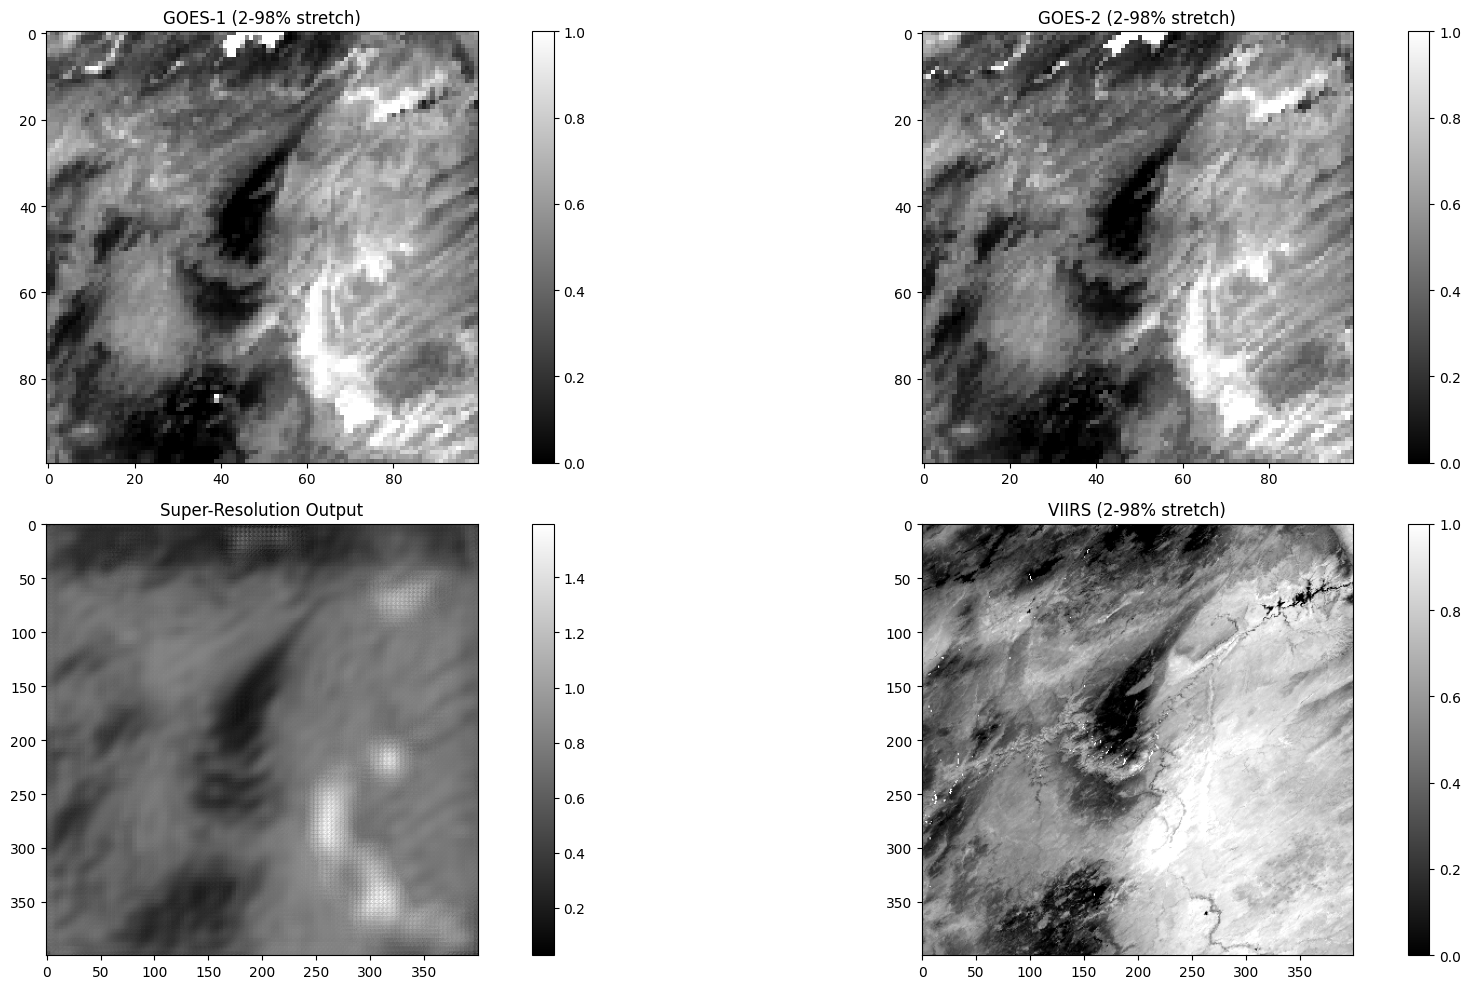

UnboundLocalError: cannot access local variable 'scale_factor' where it is not associated with a value

In [255]:
import torch
import matplotlib.pyplot as plt
import rasterio
import numpy as np
from rasterio.plot import show
import torch.nn.functional as F
import os
from PIL import Image

def run_sample_prediction(model_path, goes1_path, goes2_path, viirs_path=None, percentile_range=(2, 98)):
    """
    Run a sample prediction using the trained model and visualize the results.
    
    Args:
        model_path: Path to the trained model checkpoint
        goes1_path: Path to the first GOES satellite image
        goes2_path: Path to the second GOES satellite image
        viirs_path: Optional path to the VIIRS high-resolution image for comparison
        percentile_range: Percentile range for stretching the images
    """
    # Load the model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load the model (adjust the class name if needed)
    model = EnhancedSatelliteSuperResolutionSystem.load_from_checkpoint(model_path)
    model.to(device)
    model.eval()
    print("Model loaded successfully")
    
    # Load and preprocess the input images
    def load_and_preprocess(image_path):
        with rasterio.open(image_path) as src:
            image = src.read(1).astype(np.float32)
            metadata = src.meta.copy()
            
            # Apply percent stretch
            p_low, p_high = percentile_range
            low_val, high_val = np.percentile(image, (p_low, p_high))
            
            # Avoid division by zero
            if high_val > low_val:
                image = np.clip((image - low_val) / (high_val - low_val), 0, 1)
            else:
                image = np.zeros_like(image)
                
            return image, metadata
    
    # Load the images
    goes1_img, goes1_meta = load_and_preprocess(goes1_path)
    goes2_img, goes2_meta = load_and_preprocess(goes2_path)
    
    if viirs_path:
        viirs_img, viirs_meta = load_and_preprocess(viirs_path)
    
    # Convert to tensors
    goes1_tensor = torch.from_numpy(goes1_img).unsqueeze(0).unsqueeze(0).to(device)
    goes2_tensor = torch.from_numpy(goes2_img).unsqueeze(0).unsqueeze(0).to(device)
    
    # Process the entire image if it's small enough, otherwise process in patches
    max_size = 1024  # Maximum size to process at once
    height, width = goes1_img.shape
    
    if height <= max_size and width <= max_size:
        # Process the entire image at once
        print(f"Processing entire image of size {height}x{width}")
        with torch.no_grad():
            sr_output = model(goes1_tensor, goes2_tensor)
        sr_img = sr_output.squeeze().cpu().numpy()
    else:
        # Process in patches
        print(f"Processing image in patches (original size: {height}x{width})")
        patch_size = 100
        scale_factor = 4
        stride = patch_size  # Non-overlapping patches for simplicity
        
        # Create an empty array for the output
        sr_height = height * scale_factor
        sr_width = width * scale_factor
        sr_img = np.zeros((sr_height, sr_width), dtype=np.float32)
        
        # Process each patch
        for y in range(0, height - patch_size + 1, stride):
            for x in range(0, width - patch_size + 1, stride):
                # Extract patch
                goes1_patch = goes1_img[y:y+patch_size, x:x+patch_size]
                goes2_patch = goes2_img[y:y+patch_size, x:x+patch_size]
                
                # Convert to tensor
                goes1_patch_tensor = torch.from_numpy(goes1_patch).unsqueeze(0).unsqueeze(0).to(device)
                goes2_patch_tensor = torch.from_numpy(goes2_patch).unsqueeze(0).unsqueeze(0).to(device)
                
                # Process patch
                with torch.no_grad():
                    sr_patch = model(goes1_patch_tensor, goes2_patch_tensor)
                
                # Place in output array
                sr_patch_np = sr_patch.squeeze().cpu().numpy()
                sr_y, sr_x = y * scale_factor, x * scale_factor
                sr_img[sr_y:sr_y+patch_size*scale_factor, sr_x:sr_x+patch_size*scale_factor] = sr_patch_np
    
    # Visualize the results
    plt.figure(figsize=(20, 10))
    
    # Display GOES-1 image
    plt.subplot(2, 2, 1)
    plt.imshow(goes1_img, cmap='gray')
    plt.title(f'GOES-1 ({percentile_range[0]}-{percentile_range[1]}% stretch)')
    plt.colorbar()
    
    # Display GOES-2 image
    plt.subplot(2, 2, 2)
    plt.imshow(goes2_img, cmap='gray')
    plt.title(f'GOES-2 ({percentile_range[0]}-{percentile_range[1]}% stretch)')
    plt.colorbar()
    
    # Display super-resolution output
    plt.subplot(2, 2, 3)
    plt.imshow(sr_img, cmap='gray')
    plt.title('Super-Resolution Output')
    plt.colorbar()
    
    # Display VIIRS image if available
    if viirs_path:
        plt.subplot(2, 2, 4)
        plt.imshow(viirs_img, cmap='gray')
        plt.title(f'VIIRS ({percentile_range[0]}-{percentile_range[1]}% stretch)')
        plt.colorbar()
    
    plt.tight_layout()
    plt.savefig('super_resolution_comparison.png', dpi=300)
    plt.show()
    
    # Save the super-resolution image
    output_path = 'super_resolution_output.tif'
    
    # Update metadata for the super-resolved image
    goes1_meta.update({
        'height': sr_img.shape[0],
        'width': sr_img.shape[1],
        'transform': rasterio.Affine(
            goes1_meta['transform'].a / scale_factor,
            goes1_meta['transform'].b,
            goes1_meta['transform'].c,
            goes1_meta['transform'].d,
            goes1_meta['transform'].e / scale_factor,
            goes1_meta['transform'].f
        )
    })
    
    with rasterio.open(output_path, 'w', **goes1_meta) as dst:
        dst.write(sr_img.astype(rasterio.float32), 1)
    
    print(f"Super-resolution image saved to {output_path}")
    
    return sr_img

# Example usage:
# Replace these paths with your actual file paths
model_path = 'checkpoints one patch\enhanced-sr-epoch=03-val_psnr=13.13.ckpt'  # Replace with your model checkpoint path
goes1_path = r'Processed\ONLY_TIF\2020-05\2020-05-01_19-18\clipped_geo16.tif'  # Replace with your GOES-1 image path
goes2_path = r'Processed\ONLY_TIF\2020-05\2020-05-01_19-18\clipped_geo17.tif'  # Replace with your GOES-2 image path
viirs_path = r'Processed\ONLY_TIF\2020-05\2020-05-01_19-18\combined_clip.tif'  # Replace with your VIIRS image path (optional)

# Run the prediction
sr_img = run_sample_prediction(model_path, goes1_path, goes2_path, viirs_path)

In [252]:
# Create super-resolution image with percent stretch
model_path = r'D:\sat\checkpoints\enhanced-sr-epoch=47-val_psnr=15.53.ckpt'  # Replace with chkpt pass
goes1_path = r'Processed\ONLY_TIF\2020-05\2020-05-01_19-18\clipped_geo16.tif'
goes2_path = r'Processed\ONLY_TIF\2020-05\2020-05-01_19-18\clipped_geo17.tif'
output_path = r'Processed\ONLY_TIF\2020-05\2020-05-01_19-18\super_resolved.tif'
hr_path = r'Processed\ONLY_TIF\2020-05\2020-05-01_19-18\combined_clip.tif'

sr_output = create_super_resolution_image(
    model_path, goes1_path, goes2_path, output_path, percentile_range=(2, 98)
)

# Visualize results with percent stretch
visualize_results(goes1_path, goes2_path, output_path, hr_path, percentile_range=(2, 98))

RuntimeError: Error(s) in loading state_dict for SatelliteSuperResolutionSystem:
	Missing key(s) in state_dict: "model.encoder1.layers.0.0.weight", "model.encoder1.layers.0.0.bias", "model.encoder1.layers.0.1.weight", "model.encoder1.layers.0.1.bias", "model.encoder1.layers.0.1.running_mean", "model.encoder1.layers.0.1.running_var", "model.encoder1.layers.0.3.weight", "model.encoder1.layers.0.3.bias", "model.encoder1.layers.0.4.weight", "model.encoder1.layers.0.4.bias", "model.encoder1.layers.0.4.running_mean", "model.encoder1.layers.0.4.running_var", "model.encoder1.layers.0.6.weight", "model.encoder1.layers.0.6.bias", "model.encoder1.layers.0.7.weight", "model.encoder1.layers.0.7.bias", "model.encoder1.layers.0.7.running_mean", "model.encoder1.layers.0.7.running_var", "model.encoder1.layers.1.0.weight", "model.encoder1.layers.1.0.bias", "model.encoder1.layers.1.1.weight", "model.encoder1.layers.1.1.bias", "model.encoder1.layers.1.1.running_mean", "model.encoder1.layers.1.1.running_var", "model.encoder1.layers.1.3.weight", "model.encoder1.layers.1.3.bias", "model.encoder1.layers.1.4.weight", "model.encoder1.layers.1.4.bias", "model.encoder1.layers.1.4.running_mean", "model.encoder1.layers.1.4.running_var", "model.encoder1.layers.1.6.weight", "model.encoder1.layers.1.6.bias", "model.encoder1.layers.1.7.weight", "model.encoder1.layers.1.7.bias", "model.encoder1.layers.1.7.running_mean", "model.encoder1.layers.1.7.running_var", "model.encoder1.layers.2.0.weight", "model.encoder1.layers.2.0.bias", "model.encoder1.layers.2.1.weight", "model.encoder1.layers.2.1.bias", "model.encoder1.layers.2.1.running_mean", "model.encoder1.layers.2.1.running_var", "model.encoder1.layers.2.3.weight", "model.encoder1.layers.2.3.bias", "model.encoder1.layers.2.4.weight", "model.encoder1.layers.2.4.bias", "model.encoder1.layers.2.4.running_mean", "model.encoder1.layers.2.4.running_var", "model.encoder1.layers.2.6.weight", "model.encoder1.layers.2.6.bias", "model.encoder1.layers.2.7.weight", "model.encoder1.layers.2.7.bias", "model.encoder1.layers.2.7.running_mean", "model.encoder1.layers.2.7.running_var", "model.encoder1.layers.3.0.weight", "model.encoder1.layers.3.0.bias", "model.encoder1.layers.3.1.weight", "model.encoder1.layers.3.1.bias", "model.encoder1.layers.3.1.running_mean", "model.encoder1.layers.3.1.running_var", "model.encoder1.layers.3.3.weight", "model.encoder1.layers.3.3.bias", "model.encoder1.layers.3.4.weight", "model.encoder1.layers.3.4.bias", "model.encoder1.layers.3.4.running_mean", "model.encoder1.layers.3.4.running_var", "model.encoder1.layers.3.6.weight", "model.encoder1.layers.3.6.bias", "model.encoder1.layers.3.7.weight", "model.encoder1.layers.3.7.bias", "model.encoder1.layers.3.7.running_mean", "model.encoder1.layers.3.7.running_var", "model.encoder1.layers.4.0.weight", "model.encoder1.layers.4.0.bias", "model.encoder1.layers.4.1.weight", "model.encoder1.layers.4.1.bias", "model.encoder1.layers.4.1.running_mean", "model.encoder1.layers.4.1.running_var", "model.encoder1.layers.4.3.weight", "model.encoder1.layers.4.3.bias", "model.encoder1.layers.4.4.weight", "model.encoder1.layers.4.4.bias", "model.encoder1.layers.4.4.running_mean", "model.encoder1.layers.4.4.running_var", "model.encoder1.layers.4.6.weight", "model.encoder1.layers.4.6.bias", "model.encoder1.layers.4.7.weight", "model.encoder1.layers.4.7.bias", "model.encoder1.layers.4.7.running_mean", "model.encoder1.layers.4.7.running_var", "model.encoder2.layers.0.0.weight", "model.encoder2.layers.0.0.bias", "model.encoder2.layers.0.1.weight", "model.encoder2.layers.0.1.bias", "model.encoder2.layers.0.1.running_mean", "model.encoder2.layers.0.1.running_var", "model.encoder2.layers.0.3.weight", "model.encoder2.layers.0.3.bias", "model.encoder2.layers.0.4.weight", "model.encoder2.layers.0.4.bias", "model.encoder2.layers.0.4.running_mean", "model.encoder2.layers.0.4.running_var", "model.encoder2.layers.0.6.weight", "model.encoder2.layers.0.6.bias", "model.encoder2.layers.0.7.weight", "model.encoder2.layers.0.7.bias", "model.encoder2.layers.0.7.running_mean", "model.encoder2.layers.0.7.running_var", "model.encoder2.layers.1.0.weight", "model.encoder2.layers.1.0.bias", "model.encoder2.layers.1.1.weight", "model.encoder2.layers.1.1.bias", "model.encoder2.layers.1.1.running_mean", "model.encoder2.layers.1.1.running_var", "model.encoder2.layers.1.3.weight", "model.encoder2.layers.1.3.bias", "model.encoder2.layers.1.4.weight", "model.encoder2.layers.1.4.bias", "model.encoder2.layers.1.4.running_mean", "model.encoder2.layers.1.4.running_var", "model.encoder2.layers.1.6.weight", "model.encoder2.layers.1.6.bias", "model.encoder2.layers.1.7.weight", "model.encoder2.layers.1.7.bias", "model.encoder2.layers.1.7.running_mean", "model.encoder2.layers.1.7.running_var", "model.encoder2.layers.2.0.weight", "model.encoder2.layers.2.0.bias", "model.encoder2.layers.2.1.weight", "model.encoder2.layers.2.1.bias", "model.encoder2.layers.2.1.running_mean", "model.encoder2.layers.2.1.running_var", "model.encoder2.layers.2.3.weight", "model.encoder2.layers.2.3.bias", "model.encoder2.layers.2.4.weight", "model.encoder2.layers.2.4.bias", "model.encoder2.layers.2.4.running_mean", "model.encoder2.layers.2.4.running_var", "model.encoder2.layers.2.6.weight", "model.encoder2.layers.2.6.bias", "model.encoder2.layers.2.7.weight", "model.encoder2.layers.2.7.bias", "model.encoder2.layers.2.7.running_mean", "model.encoder2.layers.2.7.running_var", "model.encoder2.layers.3.0.weight", "model.encoder2.layers.3.0.bias", "model.encoder2.layers.3.1.weight", "model.encoder2.layers.3.1.bias", "model.encoder2.layers.3.1.running_mean", "model.encoder2.layers.3.1.running_var", "model.encoder2.layers.3.3.weight", "model.encoder2.layers.3.3.bias", "model.encoder2.layers.3.4.weight", "model.encoder2.layers.3.4.bias", "model.encoder2.layers.3.4.running_mean", "model.encoder2.layers.3.4.running_var", "model.encoder2.layers.3.6.weight", "model.encoder2.layers.3.6.bias", "model.encoder2.layers.3.7.weight", "model.encoder2.layers.3.7.bias", "model.encoder2.layers.3.7.running_mean", "model.encoder2.layers.3.7.running_var", "model.encoder2.layers.4.0.weight", "model.encoder2.layers.4.0.bias", "model.encoder2.layers.4.1.weight", "model.encoder2.layers.4.1.bias", "model.encoder2.layers.4.1.running_mean", "model.encoder2.layers.4.1.running_var", "model.encoder2.layers.4.3.weight", "model.encoder2.layers.4.3.bias", "model.encoder2.layers.4.4.weight", "model.encoder2.layers.4.4.bias", "model.encoder2.layers.4.4.running_mean", "model.encoder2.layers.4.4.running_var", "model.encoder2.layers.4.6.weight", "model.encoder2.layers.4.6.bias", "model.encoder2.layers.4.7.weight", "model.encoder2.layers.4.7.bias", "model.encoder2.layers.4.7.running_mean", "model.encoder2.layers.4.7.running_var", "model.fusion.fusion.0.weight", "model.fusion.fusion.0.bias", "model.fusion.fusion.1.weight", "model.fusion.fusion.1.bias", "model.fusion.fusion.1.running_mean", "model.fusion.fusion.1.running_var", "model.fusion.fusion.3.weight", "model.fusion.fusion.3.bias", "model.fusion.fusion.4.weight", "model.fusion.fusion.4.bias", "model.fusion.fusion.4.running_mean", "model.fusion.fusion.4.running_var", "model.fusion.fusion.6.weight", "model.fusion.fusion.6.bias", "model.fusion.fusion.7.weight", "model.fusion.fusion.7.bias", "model.fusion.fusion.7.running_mean", "model.fusion.fusion.7.running_var", "model.fusion.fusion.9.weight", "model.fusion.fusion.9.bias", "model.fusion.fusion.10.weight", "model.fusion.fusion.10.bias", "model.fusion.fusion.10.running_mean", "model.fusion.fusion.10.running_var", "model.fusion.fusion.12.weight", "model.fusion.fusion.12.bias", "model.fusion.fusion.13.weight", "model.fusion.fusion.13.bias", "model.fusion.fusion.13.running_mean", "model.fusion.fusion.13.running_var", "model.decoder.upconv.0.weight", "model.decoder.upconv.0.bias", "model.decoder.upconv.1.weight", "model.decoder.upconv.1.bias", "model.decoder.upconv.1.running_mean", "model.decoder.upconv.1.running_var", "model.decoder.upconv.3.weight", "model.decoder.upconv.3.bias", "model.decoder.upconv.4.weight", "model.decoder.upconv.4.bias", "model.decoder.upconv.4.running_mean", "model.decoder.upconv.4.running_var", "model.decoder.upconv.6.weight", "model.decoder.upconv.6.bias", "model.decoder.upconv.7.weight", "model.decoder.upconv.7.bias", "model.decoder.upconv.7.running_mean", "model.decoder.upconv.7.running_var", "model.decoder.upconv.9.weight", "model.decoder.upconv.9.bias", "model.decoder.upconv.10.weight", "model.decoder.upconv.10.bias", "model.decoder.upconv.10.running_mean", "model.decoder.upconv.10.running_var", "model.decoder.upconv.12.weight", "model.decoder.upconv.12.bias", "model.decoder.upconv.13.weight", "model.decoder.upconv.13.bias", "model.decoder.upconv.13.running_mean", "model.decoder.upconv.13.running_var", "model.decoder.upconv.15.weight", "model.decoder.upconv.15.bias", "model.decoder.upconv.16.weight", "model.decoder.upconv.16.bias", "model.decoder.upconv.16.running_mean", "model.decoder.upconv.16.running_var", "model.decoder.upconv.18.weight", "model.decoder.upconv.18.bias", "model.decoder.upconv.19.weight", "model.decoder.upconv.19.bias", "model.decoder.upconv.19.running_mean", "model.decoder.upconv.19.running_var", "model.decoder.upconv.21.weight", "model.decoder.upconv.21.bias", "model.decoder.upconv.22.weight", "model.decoder.upconv.22.bias", "model.decoder.upconv.22.running_mean", "model.decoder.upconv.22.running_var", "model.decoder.final.0.weight", "model.decoder.final.0.bias", "model.decoder.final.1.weight", "model.decoder.final.1.bias", "model.decoder.final.1.running_mean", "model.decoder.final.1.running_var", "model.decoder.final.3.weight", "model.decoder.final.3.bias". 
	Unexpected key(s) in state_dict: "model.upsampling.0.weight", "model.upsampling.0.bias", "model.upsampling.1.weight", "model.upsampling.1.bias", "model.upsampling.1.running_mean", "model.upsampling.1.running_var", "model.upsampling.1.num_batches_tracked", "model.upsampling.3.weight", "model.upsampling.3.bias", "model.upsampling.4.weight", "model.upsampling.4.bias", "model.upsampling.4.running_mean", "model.upsampling.4.running_var", "model.upsampling.4.num_batches_tracked", "model.upsampling.6.weight", "model.upsampling.6.bias", "model.encoder1.0.weight", "model.encoder1.0.bias", "model.encoder1.1.weight", "model.encoder1.1.bias", "model.encoder1.1.running_mean", "model.encoder1.1.running_var", "model.encoder1.1.num_batches_tracked", "model.encoder1.3.weight", "model.encoder1.3.bias", "model.encoder1.4.weight", "model.encoder1.4.bias", "model.encoder1.4.running_mean", "model.encoder1.4.running_var", "model.encoder1.4.num_batches_tracked", "model.encoder1.6.weight", "model.encoder1.6.bias", "model.encoder1.7.weight", "model.encoder1.7.bias", "model.encoder1.7.running_mean", "model.encoder1.7.running_var", "model.encoder1.7.num_batches_tracked", "model.encoder1.9.weight", "model.encoder1.9.bias", "model.encoder1.10.weight", "model.encoder1.10.bias", "model.encoder1.10.running_mean", "model.encoder1.10.running_var", "model.encoder1.10.num_batches_tracked", "model.encoder1.12.weight", "model.encoder1.12.bias", "model.encoder1.13.weight", "model.encoder1.13.bias", "model.encoder1.13.running_mean", "model.encoder1.13.running_var", "model.encoder1.13.num_batches_tracked", "model.encoder1.15.weight", "model.encoder1.15.bias", "model.encoder1.16.weight", "model.encoder1.16.bias", "model.encoder1.16.running_mean", "model.encoder1.16.running_var", "model.encoder1.16.num_batches_tracked", "model.encoder2.0.weight", "model.encoder2.0.bias", "model.encoder2.1.weight", "model.encoder2.1.bias", "model.encoder2.1.running_mean", "model.encoder2.1.running_var", "model.encoder2.1.num_batches_tracked", "model.encoder2.3.weight", "model.encoder2.3.bias", "model.encoder2.4.weight", "model.encoder2.4.bias", "model.encoder2.4.running_mean", "model.encoder2.4.running_var", "model.encoder2.4.num_batches_tracked", "model.encoder2.6.weight", "model.encoder2.6.bias", "model.encoder2.7.weight", "model.encoder2.7.bias", "model.encoder2.7.running_mean", "model.encoder2.7.running_var", "model.encoder2.7.num_batches_tracked", "model.encoder2.9.weight", "model.encoder2.9.bias", "model.encoder2.10.weight", "model.encoder2.10.bias", "model.encoder2.10.running_mean", "model.encoder2.10.running_var", "model.encoder2.10.num_batches_tracked", "model.encoder2.12.weight", "model.encoder2.12.bias", "model.encoder2.13.weight", "model.encoder2.13.bias", "model.encoder2.13.running_mean", "model.encoder2.13.running_var", "model.encoder2.13.num_batches_tracked", "model.encoder2.15.weight", "model.encoder2.15.bias", "model.encoder2.16.weight", "model.encoder2.16.bias", "model.encoder2.16.running_mean", "model.encoder2.16.running_var", "model.encoder2.16.num_batches_tracked", "model.fusion.0.weight", "model.fusion.0.bias", "model.fusion.1.weight", "model.fusion.1.bias", "model.fusion.1.running_mean", "model.fusion.1.running_var", "model.fusion.1.num_batches_tracked", "model.fusion.3.weight", "model.fusion.3.bias", "model.fusion.4.weight", "model.fusion.4.bias", "model.fusion.4.running_mean", "model.fusion.4.running_var", "model.fusion.4.num_batches_tracked", "model.fusion.6.weight", "model.fusion.6.bias", "model.fusion.7.weight", "model.fusion.7.bias", "model.fusion.7.running_mean", "model.fusion.7.running_var", "model.fusion.7.num_batches_tracked". 

Part 4: Model Architecture Components


Part 5: Feature Extraction and Fusion Modules

Part 6: Upsampling Module and Complete Model


Part 7: Loss Functions

Part 8: PyTorch Lightning Module
